## Model Building, Evaluation, and Optimization

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
cfb_data = pd.read_csv('data/cfb_final.csv')
cfb_data

,id,home_team,season,conference_home,firstDowns_home,fourthDownConversions_home,fourthDowns_home,fumblesLost_home,fumblesRecovered_home,games_home,...,rushingYards_away,sacks_away,tacklesForLoss_away,thirdDownConversions_away,thirdDowns_away,avgYards_away,turnovers_away,talent_away,totalPPA_away,winner
0,400787117,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,182.923077,0.000000,0.000000,6.769231,14.076923,404.615385,1.307692,379.60,251.8,H
1,400787254,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,173.416667,0.000000,0.000000,4.333333,13.000000,360.666667,1.750000,314.72,110.4,H
2,400787266,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,136.833333,0.000000,0.000000,5.750000,15.416667,315.166667,1.916667,402.58,111.7,H
3,400760497,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,244.250000,0.000000,0.000000,5.833333,13.333333,338.250000,1.833333,186.45,53.6,H
4,400787280,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,165.076923,0.000000,0.000000,5.076923,14.461538,370.615385,1.846154,331.44,127.3,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4109,401269384,Wisconsin,2020.0,Big Ten,19.571429,0.714286,1.714286,0.714286,0.571429,7.0,...,192.857143,1.142857,2.142857,5.857143,12.285714,392.000000,1.000000,594.70,374.7,H
4110,401247338,Wisconsin,2020.0,Big Ten,19.571429,0.714286,1.714286,0.714286,0.571429,7.0,...,109.375000,3.125000,5.875000,5.500000,14.250000,360.750000,1.375000,611.17,249.4,A
4111,401247297,Wisconsin,2020.0,Big Ten,19.571429,0.714286,1.714286,0.714286,0.571429,7.0,...,194.875000,2.250000,5.625000,5.375000,14.250000,347.750000,1.125000,644.09,202.5,H
4112,401249035,Wyoming,2020.0,Mountain West,18.500000,1.000000,2.000000,0.666667,1.000000,6.0,...,105.857143,2.571429,7.285714,6.000000,13.714286,347.714286,1.000000,571.21,321.2,A


## Preprocessing

We'll do some final preprocessing by utilizing `sklearn`'s `OneHotEncoder` utility to transform our `winner` column into 1 if the home team won and 0 for away. The selection of 1 for home or away is arbitrary.

In [3]:
# Replace 'winner' column with binary 'home_win' column
cfb_data = pd.concat([cfb_data, pd.get_dummies(cfb_data['winner'], drop_first=True)], axis=1)
cfb_data = cfb_data.drop(columns = 'winner')
cfb_data = cfb_data.rename(columns={'H': 'home_win'})

In [4]:
cfb_data

,id,home_team,season,conference_home,firstDowns_home,fourthDownConversions_home,fourthDowns_home,fumblesLost_home,fumblesRecovered_home,games_home,...,rushingYards_away,sacks_away,tacklesForLoss_away,thirdDownConversions_away,thirdDowns_away,avgYards_away,turnovers_away,talent_away,totalPPA_away,home_win
0,400787117,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,182.923077,0.000000,0.000000,6.769231,14.076923,404.615385,1.307692,379.60,251.8,1
1,400787254,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,173.416667,0.000000,0.000000,4.333333,13.000000,360.666667,1.750000,314.72,110.4,1
2,400787266,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,136.833333,0.000000,0.000000,5.750000,15.416667,315.166667,1.916667,402.58,111.7,1
3,400760497,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,244.250000,0.000000,0.000000,5.833333,13.333333,338.250000,1.833333,186.45,53.6,1
4,400787280,Air Force,2015.0,Mountain West,21.428571,1.000000,1.642857,0.785714,0.500000,14.0,...,165.076923,0.000000,0.000000,5.076923,14.461538,370.615385,1.846154,331.44,127.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4109,401269384,Wisconsin,2020.0,Big Ten,19.571429,0.714286,1.714286,0.714286,0.571429,7.0,...,192.857143,1.142857,2.142857,5.857143,12.285714,392.000000,1.000000,594.70,374.7,1
4110,401247338,Wisconsin,2020.0,Big Ten,19.571429,0.714286,1.714286,0.714286,0.571429,7.0,...,109.375000,3.125000,5.875000,5.500000,14.250000,360.750000,1.375000,611.17,249.4,0
4111,401247297,Wisconsin,2020.0,Big Ten,19.571429,0.714286,1.714286,0.714286,0.571429,7.0,...,194.875000,2.250000,5.625000,5.375000,14.250000,347.750000,1.125000,644.09,202.5,1
4112,401249035,Wyoming,2020.0,Mountain West,18.500000,1.000000,2.000000,0.666667,1.000000,6.0,...,105.857143,2.571429,7.285714,6.000000,13.714286,347.714286,1.000000,571.21,321.2,0


In [5]:
cfb_data['home_win'].astype('category')
# Because we'll be using ANOVA values to rank our features, we need to temporarily drop categorical features
# We'll calculate if a Chi-squared test is statistically significant in its place
X = cfb_data.drop(columns=['id', 'home_team', 'conference_home',
                    'away_team', 'conference_away', 'home_win'],axis=1)
# X = X.drop(columns=['games_home', 'games_away',
#                'away_team', 'conference_away'])
y = cfb_data['home_win']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

## Cross-Validation and Feature Selection (The Right Way)

As discussed in ESL's Chapter 7.10.2, there is a very commonly incorrect method applied to feature selection and cross-validation:

1. Out of all predictors, select the $p$ best predictors
2. Build a multivariate classifier on these predictors
3. Perform KFold cross-validation on this model to estimate test error

This will lead to inaccurate estimates of test error because our predictors cheated! They were selected on the basis of a given metric (correlation, $F_1$ or $\chi^2$ scores, etc) using ***all*** of the training data, whereas each fold in cross-validation will train a model on a subset of the data. To counteract this, we'll perform cross-validation the correct way:

1. Split our training data into K folds ($K = 10$ in this case)
2. For each iteration $k=1, 2, \dots, 10$:
    * Select the $p$ best predictors in our K - 1 training folds
    * Train our model on these predictors using all data in the K-1 folds
    * Use this model to estimate test error in the remaining Kth fold
3. Select the features that occured the most often
4. Perform cross-validation again, training a model on these chosen predictors to gain a more accurate estimate of test error
    

In [6]:
from sklearn.model_selection import KFold

In [7]:
feature_voting = pd.DataFrame({'Features': X_train.columns,
                              'Votes': 0})

# Set up KFold iteration and convert data to np array
kf = KFold(n_splits=10, random_state=1234, shuffle=True)
X = np.array(X_train)
y = np.array(y_train)

for train_index, test_index in kf.split(X):
    # Get our k-1 training folds
    X_train_k, X_test_k = X[train_index], X[test_index]
    y_train_k, y_test_k = y[train_index], y[test_index]
    
    # Calculate our ANOVA scores
    kbest = SelectKBest()
    fitted = kbest.fit(X_train_k, y_train_k)
    
    # Create a dataframe to record features and corresponding scores
    scores = pd.DataFrame(fitted.scores_)
    columns = pd.DataFrame(X_train.columns)
    selected_features = pd.concat([columns, scores],axis=1)
    selected_features.columns = ['Columns','Scores']
    
    # Gather the features that occur in the 15 highest scores
    new_cols = list(selected_features.sort_values('Scores', ascending=False)[:15]['Columns'])
    # Record if each feature occurs in the 15 highest scores
    for predictor in feature_voting['Features']:
        if predictor in new_cols:
            feature_voting.loc[feature_voting['Features'] == predictor, ['Votes']] += 1

# Glance at the distribution of appearances in the top 15
feature_voting['Votes'].value_counts()

0     52
10    10
8      3
9      2
2      1
6      1
Name: Votes, dtype: int64

In [8]:
feature_df = feature_voting.sort_values('Votes', ascending=False)
feature_df = feature_df[feature_df['Votes'] > 0].nlargest(15, columns = 'Votes')

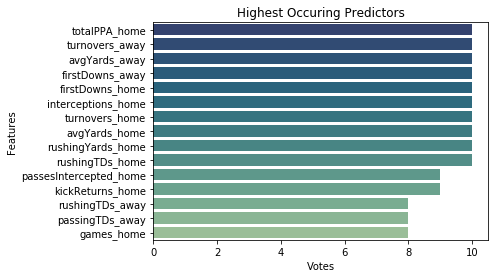

In [10]:
plt.title("Highest Occuring Predictors")
plt.xlabel('Occurences')
sns.barplot(data=feature_df[feature_df['Votes'] > 0], y='Features', x='Votes',
            orient='h', palette='crest_r')
plt.show()

In [11]:
new_features = list(feature_df['Features'])
new_X_train = X_train[new_features]
new_X_train

,totalPPA_home,turnovers_away,avgYards_away,firstDowns_away,firstDowns_home,interceptions_home,turnovers_home,avgYards_home,rushingYards_home,rushingTDs_home,passesIntercepted_home,kickReturns_home,rushingTDs_away,passingTDs_away,games_home
2392,126.8,1.461538,338.230769,17.692308,16.166667,0.333333,0.833333,322.250000,145.000000,1.166667,1.333333,1.833333,1.538462,1.307692,12.0
344,182.4,0.923077,422.307692,22.538462,15.083333,1.000000,1.416667,280.083333,114.583333,0.416667,0.750000,3.250000,2.461538,1.307692,12.0
2457,357.1,1.000000,420.846154,20.000000,17.000000,1.076923,2.000000,357.615385,190.384615,1.923077,1.230769,2.230769,2.076923,2.076923,13.0
652,104.8,1.846154,424.692308,22.538462,17.583333,1.333333,2.083333,326.500000,154.666667,0.750000,0.500000,3.333333,1.000000,1.923077,12.0
3043,385.1,1.615385,387.769231,20.538462,19.923077,0.461538,1.076923,377.538462,165.692308,1.769231,0.923077,2.692308,1.384615,1.538462,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,71.1,1.538462,366.923077,19.538462,18.333333,0.916667,1.583333,353.750000,153.250000,1.000000,0.416667,4.500000,0.692308,2.076923,12.0
1890,116.1,1.153846,430.769231,21.692308,19.000000,1.000000,2.333333,333.750000,137.500000,1.500000,0.583333,4.833333,2.076923,1.615385,12.0
350,270.9,1.583333,359.916667,18.833333,21.538462,0.461538,1.000000,412.846154,202.076923,2.769231,1.000000,3.230769,1.166667,1.750000,13.0
79,115.6,1.153846,424.000000,20.615385,14.500000,0.750000,1.666667,275.583333,164.416667,1.416667,1.083333,2.666667,2.076923,1.692308,12.0


## Estimating Test Error through Cross Validation

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

Training Logistic Regression, Random Forest, and K Nearest Neighbors models seperately:

In [13]:
# Adding StandardScaler to fix 'lbfgs failed to converge' error
log_reg = Pipeline([('scalar', StandardScaler()),
                    ('log_reg', LogisticRegression())])
cross_val_score(log_reg, new_X_train, y_train,
               cv=10, scoring='roc_auc').mean()

0.8064026001574052

In [14]:
rf = Pipeline([('scalar', StandardScaler()),
               ('random_forest', RandomForestClassifier(max_depth=10))])
cross_val_score(rf, new_X_train, y_train,
               cv=10, scoring='roc_auc').mean()

0.7992638438161017

In [15]:
# Especially important to scale KNN since sensitive to non-normalized data
knn = Pipeline([('scalar', StandardScaler()),
                ('knn', KNeighborsClassifier())])
cross_val_score(knn, new_X_train, y_train,
               cv=10, scoring='roc_auc').mean()

0.7366259805602748

More neatly with a visualization:

In [16]:
names = ['log_reg', 'rf', 'knn']
models = [LogisticRegression(), RandomForestClassifier(), KNeighborsClassifier()]
evals = pd.DataFrame({'Models': names,
             'Scores': [0, 0, 0]}, index=None)

In [17]:
for (name, model) in zip(names, models):
    model_pipe = Pipeline([('scalar', StandardScaler()), (name, model)])
    score = cross_val_score(model_pipe, new_X_train, y_train,
                   cv=10, scoring='roc_auc').mean()
    evals.loc[evals['Models'] == name, ['Scores']] = score
evals

,Models,Scores
0,log_reg,0.806403
1,rf,0.790007
2,knn,0.736626


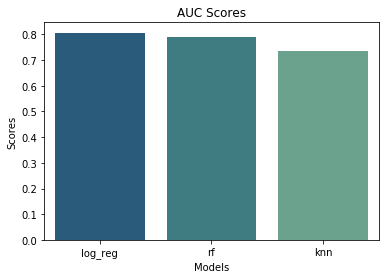

In [18]:
plt.title('AUC Scores')
sns.barplot(data=evals,x='Models', y='Scores',palette='crest_r')
plt.show()

We can see that the Logistic Regression Model just narrowly outperforms the Random Forest, with K Nearest Neighbors lagging behind. We'll stick with Logistic Regression on account of improved AUC score *and* added interpretability.

In [19]:
from sklearn import metrics

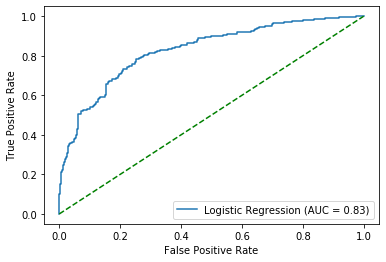

In [20]:
log_fit = log_reg.fit(new_X_train, y_train)
metrics.plot_roc_curve(log_fit, X_test[new_features], y_test, name='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='dashed', color='green')
plt.show()